# Street View House Numbers Classification



The data of the Street View House Numbers dataset, which can originally be found here are originally in .mat, i.e. files which can be best processed with MATLAB; thus, some preprocessing is required (see section 2). It is important to note that the data are divided into two formats and in this particular kernel we are going to use Format 2:

* Format 1: The original, variable-resolution colored house-number images with character level bounding boxes.
* Format 2: The cropped digits (32x32 pixels) which follow the philosophy of the MNIST dataset more closely, but also contain some distracting digits to the sides of the digit of interest.



---

### 1) Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torch.utils import data
from torch.utils.tensorboard import SummaryWriter

from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

import numpy as np
import os
from scipy.io import loadmat
import matplotlib.pyplot as plt
from torchsummary import summary

### 2) Dataset Class

To load and preprocess data  
Referred to [kaggle](https://www.kaggle.com/dimitriosroussis/svhn-classification-with-cnn-keras-96-acc) for reading mat type data

In [2]:
class SVHN(Dataset):
    
    def __init__(self, dataset_dir, data_path):
        # Using scipy's loadmat to read files of type 'mat'
        raw_data = loadmat(os.path.join(dataset_dir, data_path))
        
        images = np.array(raw_data['X'])
        # Changing axes to represent data in B, C, H, W format
        self.data = images.transpose((3, 2, 0, 1))
        
        self.labels = raw_data['y']
        # Changing labels of 0 that are set as 10 originally
        # in the dataset back to 0
        self.labels[self.labels == 10] = 0
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        
        # Normalizing data
        img = self.data[idx] / 255.
        target = np.array(self.labels[idx]).astype(np.float)
        
        return {
            'image': torch.from_numpy(img).type(torch.FloatTensor),
            'target': torch.from_numpy(target).type(torch.LongTensor).squeeze()
        }

### 3) Model Architecture

Used 4 blocks of (3 Conv layers, 1 Batch Normalization and 1 Dropout layer each)  
Each block has a residual connection with the previous block  
4 Blocks are followed by a global pooling layer and 2 linear layers, the last linear layer being the output layer  
Haven't used pooling layers as the data dimension is too low and may result in information loss.

In [3]:
class Model(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        # Block 1
        self.conv_1 = nn.Conv2d(3, 32, 3, 1)
        self.conv_2 = nn.Conv2d(32, 32, 3, 1)
        self.conv_3 = nn.Conv2d(32, 32, 3, 1)
        self.batch_1 = nn.BatchNorm2d(32)
        self.dropout_1 = nn.Dropout()
        
        # Residual Connection 1
        self.res_1 = nn.Conv2d(32, 64, 5, 1)
        
        # Block 2
        self.conv_4 = nn.Conv2d(32, 64, 3, 1)
        self.conv_5 = nn.Conv2d(64, 64, 3, 1)
        self.conv_6 = nn.Conv2d(64, 64, 3, 1)
        self.batch_2 = nn.BatchNorm2d(64)
        self.dropout_2 = nn.Dropout()
        
        # Residual Connection 2
        self.res_2 = nn.Conv2d(64, 128, 7, 1)
        
        # Block 3
        self.conv_7 = nn.Conv2d(64, 128, 3, 1)
        self.conv_8 = nn.Conv2d(128, 128, 3, 1)
        self.conv_9 = nn.Conv2d(128, 128, 3, 1)
        self.batch_3 = nn.BatchNorm2d(128)
        self.dropout_3 = nn.Dropout()
        
        # Residual Connection 3
        self.res_3 = nn.Conv2d(128, 256, 7, 1)
        
        # Block 4
        self.conv_10 = nn.Conv2d(128, 256, 3, 1)
        self.conv_11 = nn.Conv2d(256, 256, 3, 1)
        self.conv_12 = nn.Conv2d(256, 256, 3, 1)
        self.batch_4 = nn.BatchNorm2d(256)
        self.dropout_4 = nn.Dropout()
        
        # Residual Connection 4
        self.res_4 = nn.Conv2d(256, 256, 5, 1)
        
        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d(1)
        
        # Fully connected layers
        self.linear_1 = nn.Linear(256, 64)
        self.output = nn.Linear(64, 10)
    
    def forward(self, x):
        
        # First Block
        x = F.relu(self.conv_1(x))
        x = F.relu(self.conv_2(x))
        
        # First residual branch
        res_1 = F.relu(self.res_1(x))
        
        x = F.relu(self.conv_3(x))
        x = self.batch_1(x)
        x = self.dropout_1(x)
        
        # Second block
        x = F.relu(self.conv_4(x))
        
        # Adding residual connection from first block
        add_1 = torch.add(x, res_1)
        # Second residual branch
        res_2 = F.relu(self.res_2(add_1))
        
        x = F.relu(self.conv_5(add_1))
        x = F.relu(self.conv_6(x))
        x = self.batch_2(x)
        x = self.dropout_2(x)
        
        # Third block
        x = F.relu(self.conv_7(x))
        
        # Adding residual connection from second block
        add_2 = torch.add(x, res_2)
        # Third residual branch
        res_3 = F.relu(self.res_3(add_2))
        
        x = F.relu(self.conv_8(x))
        x = F.relu(self.conv_9(x))
        x = self.batch_3(x)
        x = self.dropout_3(x)
        
        # Fourth block
        x = F.relu(self.conv_10(x))
        
        # Adding residual connection from third block
        add_3 = torch.add(x, res_3)
        # Fourth residual branch
        res_4 = F.relu(self.res_4(add_3))
        
        x = F.relu(self.conv_11(x))
        x = F.relu(self.conv_12(x))
        x = self.batch_4(x)
        x = self.dropout_4(x)
        
        # Adding residual connection from fourth block
        add_4 = torch.add(x, res_4)
        # Global Average Pooling
        x = self.gap(add_4)
        
        x = x.reshape(x.size(0), -1)
        
        x = F.relu(self.linear_1(x))
        
        return self.output(x)

### 4) Config Parameters

In [4]:
DATASET_DIR = '/home/praneet/Downloads'
TRAIN_PATH = 'train_32x32.mat'
TEST_PATH = 'test_32x32.mat'
WIDTH = 32
HEIGHT = 32
LEARNING_RATE = 0.001
EPOCHS = 100
BATCH_SIZE = 32

### 5) Early Stopping

In [5]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

### 6) SVHN Classifier

This class handles all the parts of the whole pipeline  
It includes, data loading and preparing, initializing the model and other hyperparameters  
It also includes training, evaluating, inferencing, loading and saving models

In [6]:
class SVHNClassifier():
    
    def __init__(self, model, mode='eval', model_path=None, LEARNING_RATE=0.0001, BATCH_SIZE=16):
        
        # Initializing config parameters
        self.HEIGHT = HEIGHT
        self.WIDTH= WIDTH
        self.CHANNELS = 3
        self.BATCH_SIZE = BATCH_SIZE
        self.VAL_SPLIT = 0.1
        self.EPOCHS = EPOCHS
        self.LEARNING_RATE = LEARNING_RATE
        self.mode = mode
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        # Loading the model in different modes
        if mode in ['train', 'test']:
            
            self.model = model.to(self.device)
            
            self.criterion = nn.CrossEntropyLoss()

            self.optimizer = torch.optim.Adam(self.model.parameters(), 
                                              lr=self.LEARNING_RATE)
            
            # If the class is initialized in testing mode, training data is not loaded
            if mode == "test":
                assert model_path is not None, "Please provide model path to test"
                self.load_model(model_path)
            else:
                
                # Loading and splitting the dataset into train and val sets
                train_dataset = SVHN(DATASET_DIR, TRAIN_PATH)

                VAL_DATA_LEN = int(len(train_dataset) * self.VAL_SPLIT)
                TRAIN_DATA_LEN = len(train_dataset) - VAL_DATA_LEN

                self.train_set, self.val_set = data.random_split(train_dataset, 
                                                                 [TRAIN_DATA_LEN, 
                                                                  VAL_DATA_LEN])
            # Loading the test set
            self.test_set = SVHN(DATASET_DIR, TEST_PATH)
            
            # Loss and accuracy history lists
            self.train_loss_history = []
            self.val_loss_history = []
            
            self.train_acc_history = []
            self.val_acc_history = []
            
        else:
            # Loading in inference mode where datasets are not required
            assert model_path is not None, "Please provide model path to use"
            self.model = model.to(self.device)
            self.criterion = nn.CrossEntropyLoss()

            self.optimizer = torch.optim.Adam(self.model.parameters(), 
                                              lr=self.LEARNING_RATE)
            if model_path.endswith('pth'):
                self.load_model(model_path)
            elif model_path.endswith('pt'):
                self.load_state_dict(model_path)
    
    def train(self):
        """
            Trains the model on given epochs in the config parameter
        """
        
        # Tensorboard summary writer for maintaining logs
        writer = SummaryWriter(comment=f"{type(self.model).__name__}_LR_{LEARNING_RATE}_EPOCHS_{self.EPOCHS}_VAL_LOSS")
        
        # Early stopping for stopping the training after the val loss starts increasing or diverging
        early_stopping = EarlyStopping(patience=10, verbose=True, path='val_loss.pt')
    
        # Training loop
        for epoch in range(1, self.EPOCHS + 1):

            train_loss = 0.0
            train_acc = 0.0
            train_loss_history = []
            train_acc_history = []
            
            self.model.train()
            for idx, sample in enumerate(self.training_data):
                
                # Iterating over data and moving it to GPU
                image = sample['image'].to(self.device)
                target = sample['target'].to(self.device)
                
                # Forward Pass
                outputs = F.softmax(self.model(image), dim=1)
                
                # Calculating the class predictions
                _, correct_predictions = torch.max(outputs, 1)          
                
                # Calculating loss
                loss = self.criterion(outputs, target)
                
                # Backpropagation
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                # Maintaining training logs
                train_acc_history.append(torch.sum(correct_predictions == target).item() / self.BATCH_SIZE)
                train_loss_history.append(loss.item() / self.BATCH_SIZE)
                
                # Printing metrics in place
                print(f"Epoch {epoch}: Batch ({idx+1}/{len(self.training_data)}) \
                      Training Accuracy: {round(sum(train_acc_history) / (idx+1), 5)} \
                      Training Loss: {round(sum(train_loss_history) / (idx+1), 5)}", end="\r")

            else:
                # Evaluating model on validation set
                val_acc, val_loss = self.evaluate(self.validation_data)
                
                # Calculating metrics
                train_acc = sum(train_acc_history) / (idx+1)
                train_loss = sum(train_loss_history) / (idx+1)
                
                self.train_acc_history.append(train_acc)
                self.val_acc_history.append(val_acc)
                
                self.train_loss_history.append(train_loss)
                self.val_loss_history.append(val_loss)
                
                # Writing training logs to tensorboard
                writer.add_scalar('Accuracy/train', train_acc, epoch)
                writer.add_scalar('Accuracy/validation', val_acc, epoch)
                
                # Writing evaluation logs to tensorboard
                writer.add_scalar('Loss/train', train_loss / (idx+1), epoch)
                writer.add_scalar('Loss/validation', val_loss, epoch)
                
                print(f"Epoch {epoch}: \
                      Training Accuracy: {round(train_acc, 5)} \
                      Training Loss: {round(train_loss, 5)} \
                      Validation Accuracy: {round(val_acc, 5)} \
                      Validation Loss: {round(val_loss, 5)}")
                
            early_stopping(val_loss, self.model)
            
            # If early stopping is triggered, training loop will stop
            if early_stopping.early_stop:
                print("Early stopping")
                break

        # Closing tensorboard connection
        writer.flush()
        writer.close()
        
        # Saving best and latest model
        model_name = f"LR_{self.LEARNING_RATE}_EPOCHS_{self.EPOCHS}.pth"
        best_model_name = f"BEST_LR_{self.LEARNING_RATE}_EPOCHS_{self.EPOCHS}.pth"
        self.save_model(model_name)
        self.load_state_dict('val_loss.pt')
        self.save_model(best_model_name)
    
    def evaluate(self, test_data=None):
        """
        Evaluates the model on the given test data
        Args:
            test_data: Custom test data for evaluation
        Returns:
            test_acc: Test Set accuracy
            test_loss: Test Set loss
        """
        
        # If custom test data is not given, use the initialized test data
        if test_data is None:
            test_data = self.test_data
        
        # Setting the model in evaluation mode
        self.model.eval()
        test_loss = 0.0
        test_acc = 0.0
        
        # Evaluating the model without calculating gradients
        with torch.no_grad():
            
            for sample in test_data:
                image = sample['image'].to(self.device)
                target = sample['target'].to(self.device)

                outputs = F.softmax(self.model(image), dim=1)
                
                correct_predictions = torch.max(outputs, 1)[-1]
                test_acc += torch.sum(correct_predictions == target).item() / self.BATCH_SIZE
                                                  
                pred_loss = self.criterion(outputs, target)    
                test_loss += pred_loss.item() / self.BATCH_SIZE
                
            test_loss = test_loss / len(test_data)
            test_acc = test_acc / len(test_data)
        
        return test_acc, test_loss
    
    def prepare_dataset(self):
        """
        Prepares dataset with dataloaders and given transforms, setting different parameters
        """
        
        if self.mode == 'train':
        
            self.training_data = data.DataLoader(self.train_set,
                                                 batch_size=self.BATCH_SIZE,
                                                 shuffle=True,
                                                 num_workers=2)
            self.validation_data = data.DataLoader(self.val_set,
                                                   batch_size=self.BATCH_SIZE,
                                                   shuffle=True,
                                                   num_workers=2)
        self.test_data = data.DataLoader(self.test_set,
                                         batch_size=self.BATCH_SIZE,
                                         shuffle=True,
                                         num_workers=2)
    
    def inference(self, image):
        """
        Inferences given examples in eval mode
        
        """
        image = image.to(self.device)
        
        if len(image.shape) < 4:
            image = torch.unsqueeze(image, 0)
        
        self.model.eval()
        with torch.no_grad():
            return F.softmax(self.model(image), dim=1)
    
    def save_model(self, file_path='torch_model.pth'):
        """
        Saves model with the given name and saves other metrics and log history with it.
        """
        torch.save({
            'epochs': self.EPOCHS,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_loss_history': self.train_loss_history,
            'val_loss_history': self.val_loss_history
            }, file_path)
        
        print(f"Model saved to {file_path}")
    
    def load_model(self, file_path='torch_model.pth'):
        """
        Loads model with the given name and loads other metrics and log history with it
        """
        checkpoint = torch.load(file_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.EPOCHS = checkpoint['epochs']
        self.train_loss_history = checkpoint['train_loss_history']
        self.val_loss_history = checkpoint['val_loss_history']
        
        print(f"Model loaded from {file_path}")
    
    def load_state_dict(self, file_path='loss.pt'):
        """
        Loads the model weights only saved by early stopping
        """
        
        self.model.load_state_dict(torch.load(file_path))
        
        print(f"Model state dict loaded from {file_path}")

### 7) Initializing classifier and preparing dataset

In [ ]:
classifier = SVHNClassifier(Model(), 'train')
classifier.prepare_dataset()
summary(classifier.model, input_size=(3, 32, 32))

In [1]:
classifier.train()

### 8) Loading classifier in test mode

In [7]:
classifier = SVHNClassifier(Model(), 'test', 'BEST_LR_0.0001_EPOCHS_100.pth')
classifier.prepare_dataset()

Model loaded from BEST_LR_0.0001_EPOCHS_100.pth


In [8]:
test_acc, test_loss = classifier.evaluate()
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

Test Accuracy: 0.9320451751690227
Test Loss: 0.09555236087595677


### 9) Visualizing predictions and activations using GradCAM

Used library from [here](https://github.com/jacobgil/pytorch-grad-cam) implemented by **jacobgil**

In [27]:
sample = next(iter(classifier.test_data))
input_tensor = sample['image'][0].unsqueeze(0)
rgb_image = input_tensor.squeeze().numpy().transpose((1, 2, 0))
with torch.no_grad():
    output = classifier.model(input_tensor.to(classifier.device))
predicted_output = torch.max(output, 1)[-1][0].item()

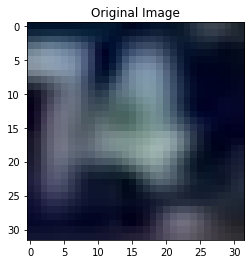

In [28]:
plt.imshow(rgb_image)
plt.title("Original Image")
plt.show()

In [29]:
# Setting gap layer as the visualization layer
target_layer = classifier.model.conv_10
cam = GradCAMPlusPlus(model=classifier.model, target_layer=target_layer, use_cuda=True)
grayscale_cam = cam(input_tensor=input_tensor.to(classifier.device))
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_image, grayscale_cam)

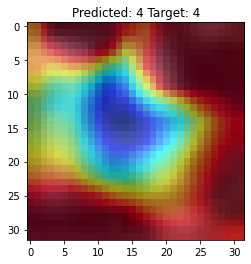

In [30]:
plt.imshow(visualization)
plt.title("Predicted: " + str(predicted_output) + " Target: " + str(sample['target'][0].item()))
plt.show()